In [32]:
import numpy as np
import cv2

images = [cv2.imread('data/hyu_{}.jpeg'.format(i)) for i in range(3)]
# images = [cv2.imread('data/Aerial_{}.jpg'.format(i)) for i in range(3)]
grays = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]


sift = cv2.xfeatures2d.SIFT_create()
kps = []
descs = []
for gray in grays:
    kp, desc = sift.detectAndCompute(gray, None)
    kps.append(kp)
    descs.append(desc)

bf = cv2.BFMatcher()
matches1 = bf.match(descs[0], descs[1])     # between image 0 and image 1
matches2 = bf.match(descs[2], descs[1])     # between image 2 and image 1

In [28]:

sorted_matches = sorted(matches1, key = lambda x : x.distance)
res = cv2.drawMatches(images[0], kps[0], images[1], kps[1], sorted_matches[:50], None, flags = 2)

from PIL import Image
Image.fromarray(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [ ]:
sorted_matches = sorted(matches2, key = lambda x : x.distance)
res = cv2.drawMatches(images[2], kps[2], images[1], kps[1], sorted_matches[:50], None, flags = 2)

from PIL import Image
Image.fromarray(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [169]:
height, width, _ = images[0].shape
result = np.zeros((height, width * 3, 3), dtype = np.uint8)

# Stitch image2 to image1
src = np.float32([kps[2][m.queryIdx].pt for m in matches2]).reshape((-1, 1, 2))
dst = np.float32([kps[1][m.trainIdx].pt for m in matches2]).reshape((-1, 1, 2))
H, status = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)


######################### Back Projection #####################
H_inv = np.linalg.inv(H)

for x in range(width*2):
    x_d = x
    for y in range(height):
        dst_point = np.array([x_d, y, 1])

        src_point = np.dot(H_inv, dst_point)
        src_point /= src_point[2]
        src_x, src_y = int(src_point[0]), int(src_point[1])

        if 0 <= src_x < width and 0 <= src_y < height:
            result[y, x_d + width] = images[2][src_y, src_x]

## Alpha blending
alpha = np.linspace(0, 1, 200).reshape(1, -1, 1)
overlap_src = result[:, width*2-200:width*2]
overlap_dst = images[1][:, width-200:]
blended_2 = overlap_src * alpha + overlap_dst * (1-alpha)
#############################################

# # Prepare pixel coordinates in image1
# before = []
# for x in range(images[2].shape[1]):
#     for y in range(images[2].shape[0]):
#         point = [x, y, 1]
#         before.append(point)
# before = np.array(before).transpose()

# # [TODO] Calculate coordinates for each pixel in image1 to image 2
# after = np.dot(H, before)
# after = after / after[2, :]
# after = after[:2, :]
# after = np.round(after, 0).astype(int)


# for pt1, pt2 in zip(before[:2, :].transpose(), after.transpose()):
#     if pt2[1] >= height:
#         continue

#     if np.sum(pt2 < 0) >= 1:
#         continue

#     result[pt2[1], width+pt2[0]] = images[2][pt1[1], pt1[0]]

###############################################

# Stitch image0 to image1
src = np.float32([kps[0][m.queryIdx].pt for m in matches1]).reshape((-1, 1, 2))
dst = np.float32([kps[1][m.trainIdx].pt for m in matches1]).reshape((-1, 1, 2))
H, status = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)

###################### Back Projection #########################

H_inv = np.linalg.inv(H)

for x in range(width*2):
    x_d = x - width
    for y in range(height):
        dst_point = np.array([x_d, y, 1])

        src_point = np.dot(H_inv, dst_point)
        src_point /= src_point[2]
        src_x, src_y = int(src_point[0]), int(src_point[1])

        if 0 <= src_x < width and 0 <= src_y < height:
            result[y, x_d + width] = images[0][src_y, src_x]

## Alpha blending
alpha = np.linspace(0, 1, 200).reshape(1, -1, 1)
overlap_src = result[:, width:width+200]
overlap_dst = images[1][:, :200]
blended_1 = overlap_src * (1-alpha) + overlap_dst * alpha
###############################################

# # Prepare pixel coordinates in image1
# before = []
# for x in range(images[1].shape[1]):
#     for y in range(images[1].shape[0]):
#         point = [x, y, 1]
#         before.append(point)
# before = np.array(before).transpose()

# # [TODO] Calculate coordinates for each pixel in image1 to image 0
# after = np.dot(H, before)
# after = after / after[2, :]
# after = after[:2, :]
# after = after.astype(int)
# after[0] += width

# for pt1, pt2 in zip(before[:2, :].transpose(), after.transpose()):
#     if pt2[1] < 0 or pt2[1] >= height:
#         continue

#     if any(pt2 < 0):
#         continue

#     result[pt2[1], pt2[0]] = images[0][pt1[1], pt1[0]]

###############################################

result[0:height, width:width*2] = images[1]
result[:, width:width+200] = blended_1
result[:, width*2-200:width*2] = blended_2


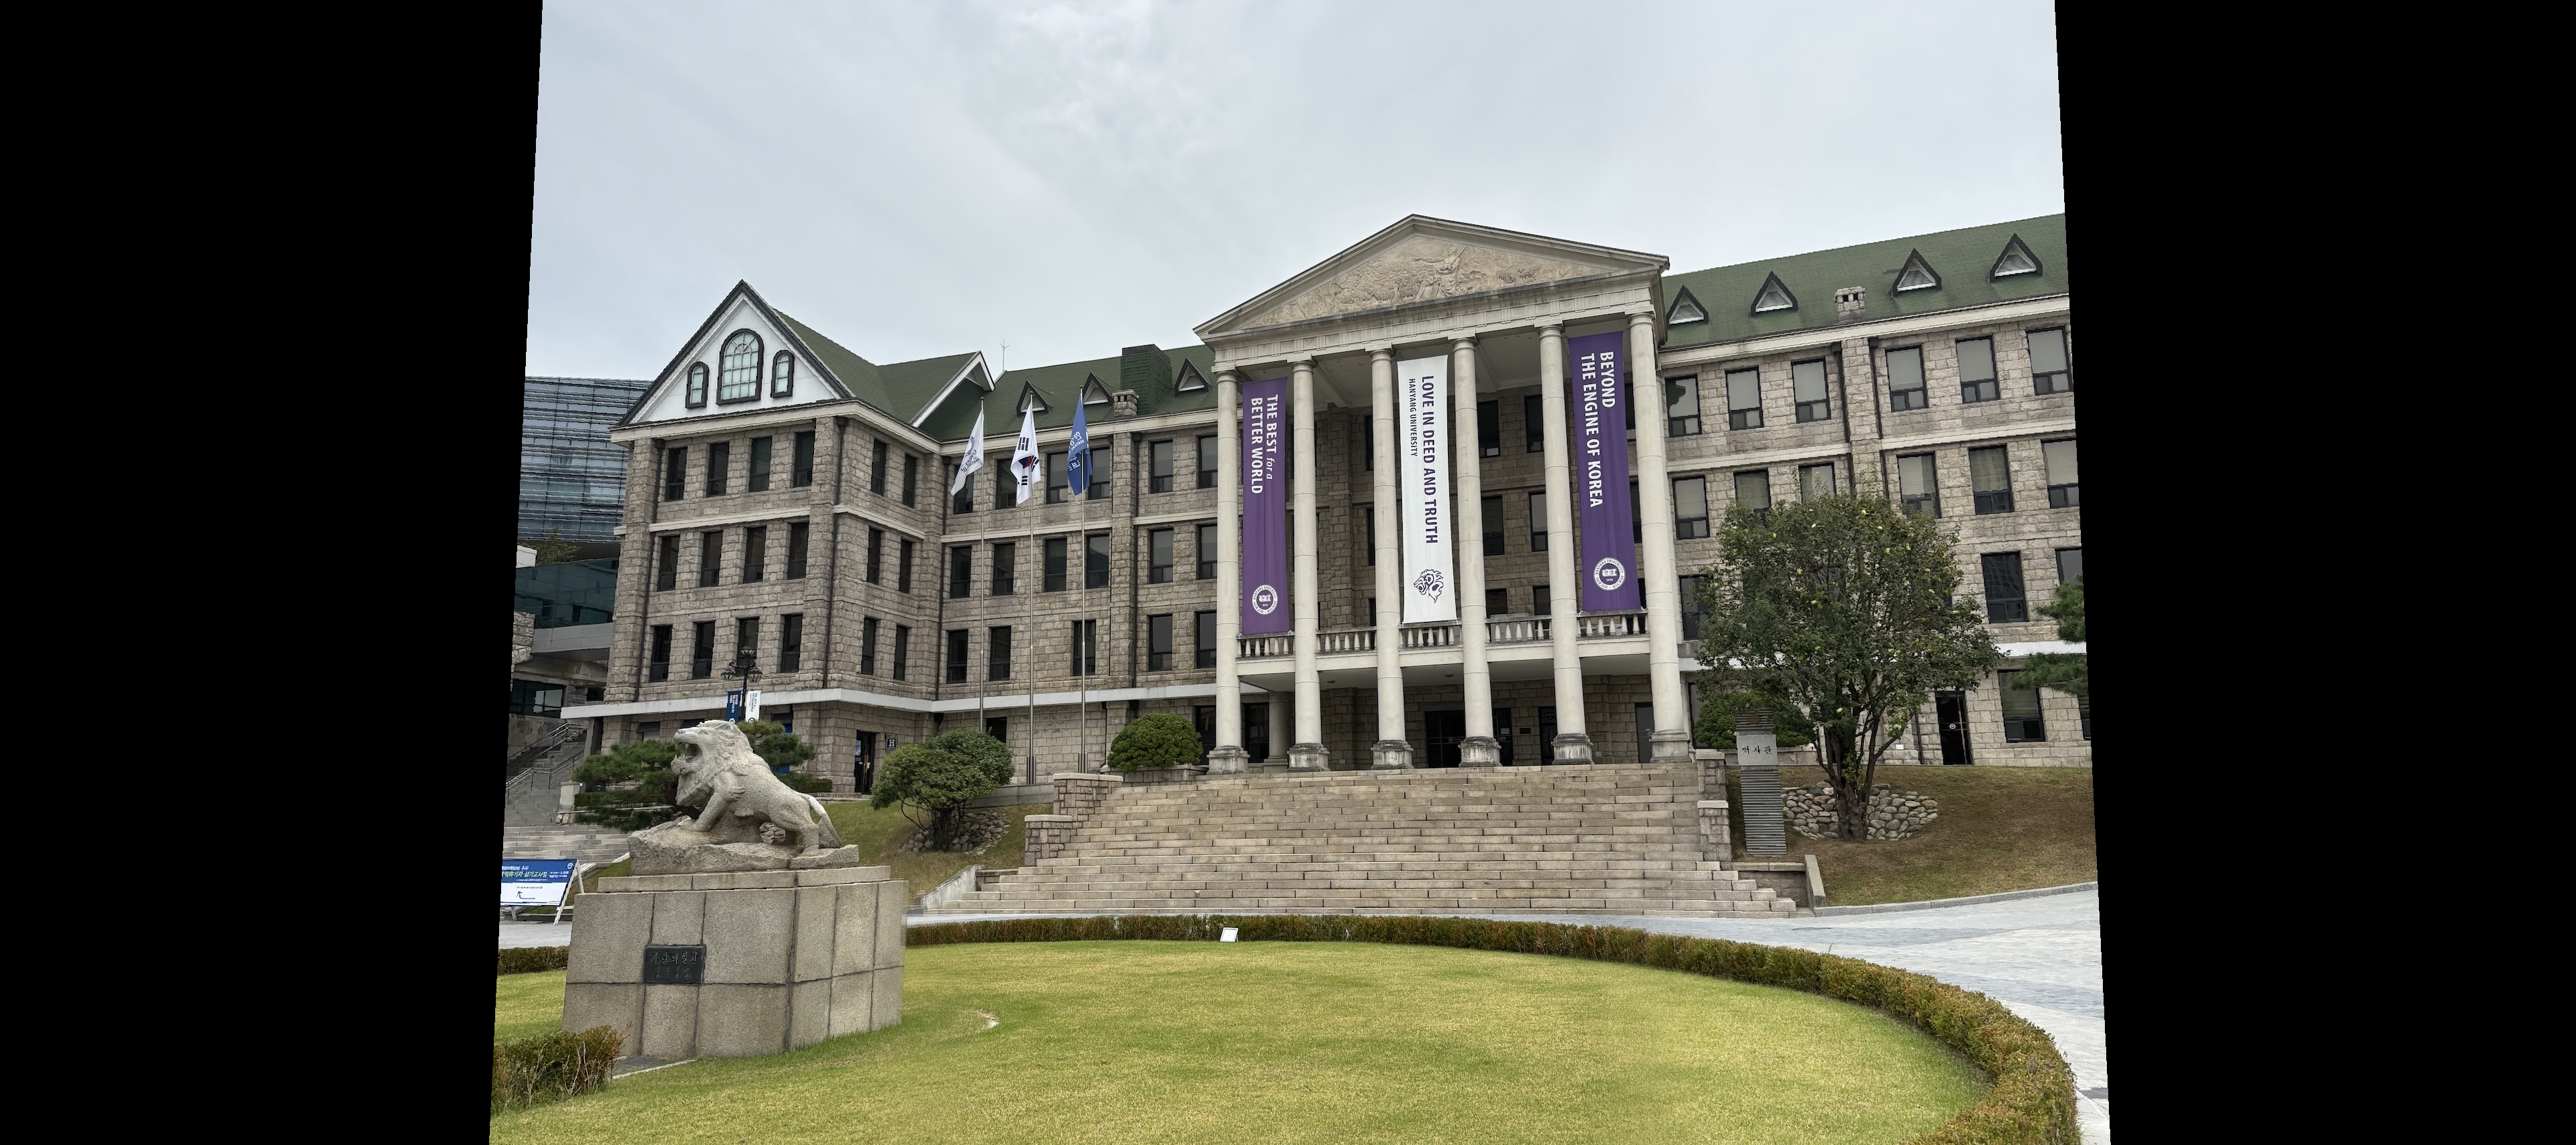

In [170]:
from PIL import Image
Image.fromarray(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))